In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
local_zip = '/content/drive/MyDrive/Scoliosis/archive4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset/')
zip_ref.close()
base_dir = '/content/dataset/archive'

In [4]:
total = 0
labels = {}
for i in os.listdir(base_dir):
    imgCount = len(os.listdir(os.path.join(base_dir, i)))
    labels[i] = imgCount
    total += imgCount

print(os.listdir(base_dir))
print("Total : " + str(total))

['scoliosis', 'normal']
Total : 210


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=(416, 416),
    batch_size=64,
    seed=999
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=(416, 416),
    batch_size=64,
    seed=999
)

Found 168 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [6]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(416,
                                  416,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

In [7]:
from tensorflow.keras.applications import ResNet50

base_resnet_model = ResNet50(include_top=False,
                   input_shape=(416, 416, 3),
                   pooling='max',classes=2,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [9]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [10]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 416, 416, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,723,138
Trainable params: 135,426
Non

In [11]:
resnet_hist = resnet_model.fit(
    train_data,
    epochs=50,
    validation_data = valid_data
)

Epoch 1/50
3/3 [==============================] - 26s 5s/step - loss: 2.1299 - accuracy: 0.4881 - val_loss: 0.8595 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 4s 2s/step - loss: 0.8596 - accuracy: 0.5357 - val_loss: 0.9334 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 5s 1s/step - loss: 0.7594 - accuracy: 0.5476 - val_loss: 0.8866 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 0.7738 - accuracy: 0.4940 - val_loss: 0.6984 - val_accuracy: 0.4762
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.6764 - accuracy: 0.5000 - val_loss: 0.7043 - val_accuracy: 0.4762
Epoch 6/50
3/3 [==============================] - 5s 1s/step - loss: 0.6568 - accuracy: 0.5952 - val_loss: 0.7454 - val_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.6483 - accuracy: 0.5714 - val_loss: 0.6857 - val_accuracy: 0.7619
Epoch 8/50
3/3 [========================

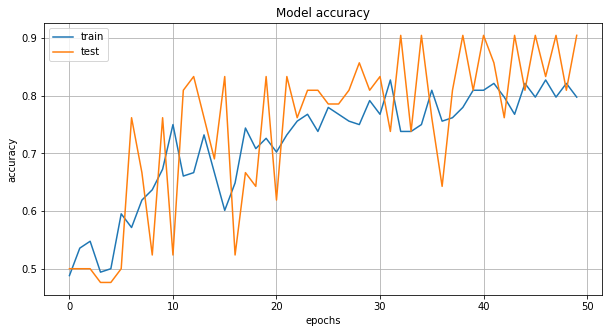

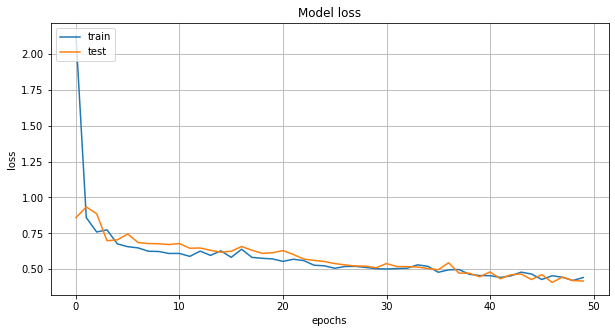

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

Saving 0001.jpg to 0001.jpg
0001.jpg
Normal


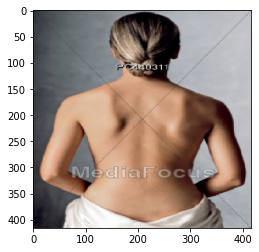

In [17]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(416,416))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = resnet_model.predict(images, batch_size=64)
  classes = np.argmax(classes)
  
  print(fn)
  if classes==0:
    print('Normal')
  elif classes==1:
    print('Scoliosis')

In [18]:
resnet_model.save('drive/MyDrive/Scoliosis/scoliosis-model-new.h5')